Loading real data...
Accuracy: 0.7880


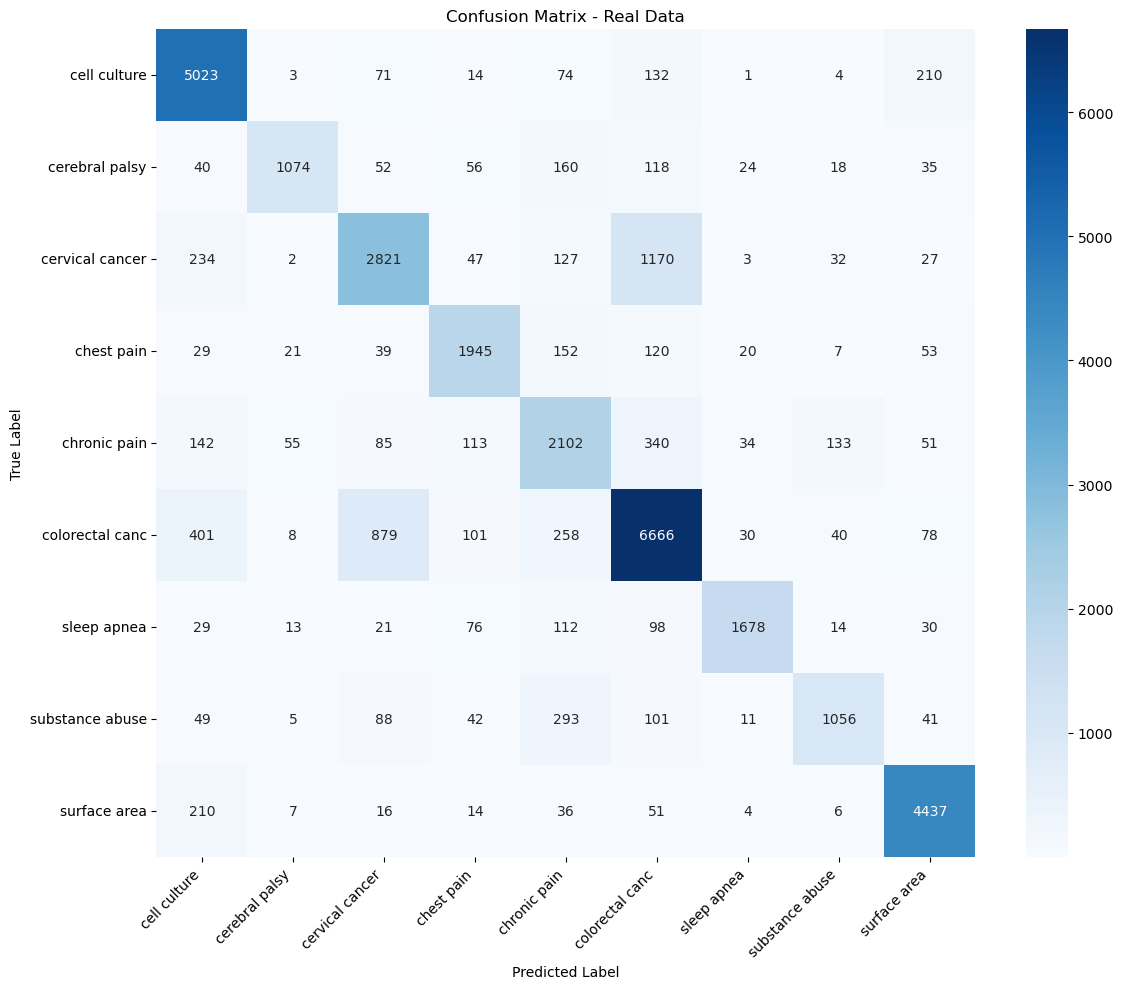


Per-Abbreviation Performance:


,Abbreviation,Accuracy,Count
0,CC,0.786194,18456
1,CP,0.729695,7018
2,SA,0.839892,8538


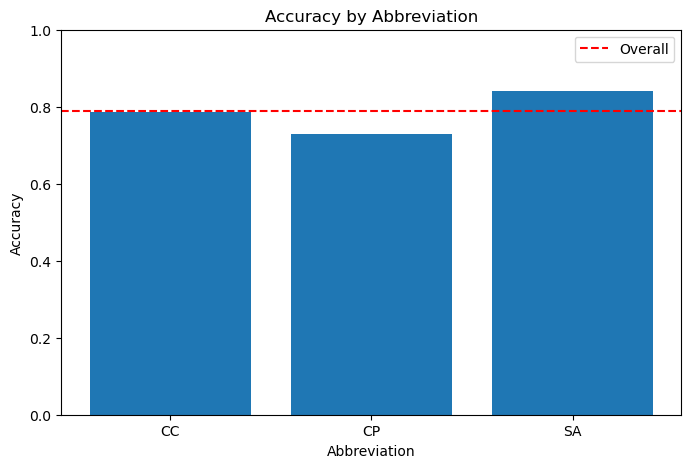


Per-Class Metrics:


,precision,recall,f1
cell culture,0.815800,0.908000,0.859400
cerebral palsy,0.904000,0.681000,0.776900
cervical cancer,0.692800,0.632100,0.661000
chest pain,0.807700,0.815200,0.811400
chronic pain,0.634300,0.688100,0.660100
colorectal cancer,0.757800,0.787900,0.772600
sleep apnea,0.929600,0.810200,0.865800
substance abuse,0.806100,0.626300,0.704900
surface area,0.894200,0.928000,0.910800



Most Confused Pairs:


,True,Predicted,Count
20,cervical cancer,colorectal cancer,1170
42,colorectal cancer,cervical cancer,879
40,colorectal cancer,cell culture,401
36,chronic pain,colorectal cancer,340
60,substance abuse,chronic pain,293
44,colorectal cancer,chronic pain,258
16,cervical cancer,cell culture,234
64,surface area,cell culture,210
7,cell culture,surface area,210
11,cerebral palsy,chronic pain,160



Failure Examples:


,Abbrev,True,Predicted,Context
0,CP,chronic pain,colorectal cancer,patients n undergoing treatment for at four cl...
1,CC,colorectal cancer,chest pain,present as a symptom of thus patients with a s...
2,CP,cerebral palsy,surface area,the is highly actual issue of...
3,CC,colorectal cancer,cervical cancer,in more than of human g1 î²catenin stimulates ...
4,SA,surface area,cell culture,other substrates when accounting for sa all st...
5,CC,cervical cancer,cell culture,novel peptide probes specific to were develope...
6,CP,chest pain,colorectal cancer,for patients with unclear acute although the u...
7,CC,colorectal cancer,cervical cancer,and relative emmprin expression in cells and t...
8,CC,colorectal cancer,cell culture,tianfoshen oral liquid in future treatments...
9,CP,cerebral palsy,chronic pain,with crippled children suffering from a descri...


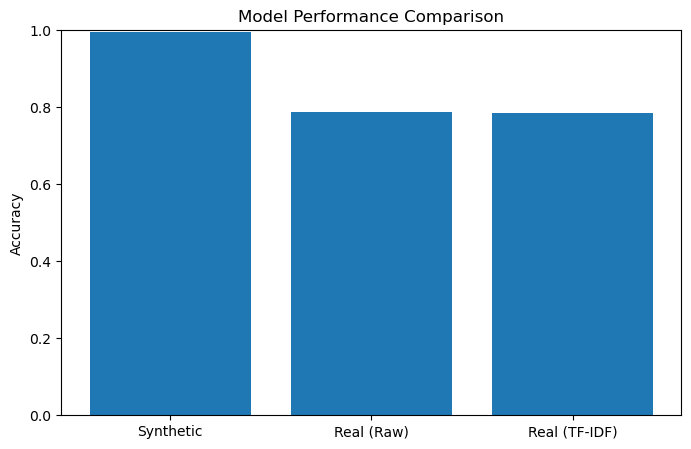

In [4]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from src.data_loader import load_synthetic, load_real
from src.feature_extraction import process_data, extract_context
from src.models import MultinomialNB
from src.tfidf import compute_tfidf
from src.evaluation import calculate_metrics, confusion_matrix

# Load and process data
print("Loading real data...")
real_df = pd.read_csv('../data/filtered_dataset.csv') 
X, y, vocab = process_data(real_df, min_freq=3)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, np.arange(len(X)), test_size=0.3, random_state=42, stratify=y
)

# Train model
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print(f"Accuracy: {(y_pred == y_test).mean():.4f}")

# 1. CONFUSION MATRIX HEATMAP
classes = np.unique(y_train)
cm = confusion_matrix(y_test, y_pred, classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[c[:15] for c in classes], 
            yticklabels=[c[:15] for c in classes])
plt.title('Confusion Matrix - Real Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. PER-ABBREVIATION PERFORMANCE
abbrev_results = []
for abbrev in ['CC', 'CP', 'SA']:
    mask = real_df.loc[idx_test, 'abbreviation'].values == abbrev
    abbrev_true = y_test[mask]
    abbrev_pred = y_pred[mask]
    accuracy = (abbrev_true == abbrev_pred).mean()
    abbrev_results.append({'Abbreviation': abbrev, 'Accuracy': accuracy, 'Count': mask.sum()})

abbrev_df = pd.DataFrame(abbrev_results)
print("\nPer-Abbreviation Performance:")
display(abbrev_df)

plt.figure(figsize=(8, 5))
plt.bar(abbrev_df['Abbreviation'], abbrev_df['Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Abbreviation')
plt.title('Accuracy by Abbreviation')
plt.ylim(0, 1)
plt.axhline(y=0.788, color='r', linestyle='--', label='Overall')
plt.legend()
plt.savefig('results/per_abbrev_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. CLASS-WISE METRICS TABLE
metrics = calculate_metrics(y_test, y_pred, classes)
metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df.round(4)
print("\nPer-Class Metrics:")
display(metrics_df.style.background_gradient(cmap='RdYlGn', vmin=0.5, vmax=1.0))

# 4. MOST CONFUSED PAIRS
confusion_pairs = []
for i, true_class in enumerate(classes):
    for j, pred_class in enumerate(classes):
        if i != j and cm.iloc[i, j] > 0:
            confusion_pairs.append({
                'True': true_class,
                'Predicted': pred_class,
                'Count': cm.iloc[i, j]
            })

confusion_df = pd.DataFrame(confusion_pairs).sort_values('Count', ascending=False).head(10)
print("\nMost Confused Pairs:")
display(confusion_df)

# 5. FAILURE EXAMPLES
failure_mask = y_pred != y_test
failure_indices = idx_test[failure_mask]
sample_failures = np.random.choice(failure_indices, size=15, replace=False)

failure_examples = []
for idx in sample_failures:
    row = real_df.loc[idx]
    pred_idx = np.where(idx_test == idx)[0][0]
    context_words = extract_context(row)
    failure_examples.append({
        'Abbrev': row['abbreviation'],
        'True': row['label'],
        'Predicted': y_pred[pred_idx],
        'Context': ' '.join(context_words[:20]) + '...'
    })

failure_df = pd.DataFrame(failure_examples)
print("\nFailure Examples:")
display(failure_df)

# 6. COMPARISON: SYNTHETIC VS REAL
comparison = pd.DataFrame({
    'Dataset': ['Synthetic', 'Real (Raw)', 'Real (TF-IDF)'],
    'Accuracy': [0.9963, 0.7880, 0.7845]
})

plt.figure(figsize=(8, 5))
plt.bar(comparison['Dataset'], comparison['Accuracy'])
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.savefig('results/comparison.png', dpi=300, bbox_inches='tight')
plt.show()